In [1]:
cd ../dataprocessing

/Users/carverforbes/internships/google/gunshot-detection/activity-recognition/location/lbs/activity/audioset/dataprocessing


In [2]:
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import np_utils
from sklearn import metrics
from sklearn.model_selection import train_test_split

/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
print(os.path.dirname(os.path.realpath('__file__')))

/Users/carverforbes/internships/google/gunshot-detection/activity-recognition/location/lbs/activity/audioset/dataprocessing


In [4]:
debug = False
logging.set_verbosity(logging.INFO)

In [408]:
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
# filenames should adhere to the following order
# [dataset, validation set, test set]
filenames = ['test_set2']
labels = ['Gunshot, gunfire']
features_to_extract = ['mfcc']

In [409]:
def get_dataframes():
    length = len(filenames)
    if length == 3:
        dataset_df = ap.output_df(src_dir, dest_dir, filenames[0], labels, features_to_extract)
        evaluation_df = ap.output_df(src_dir, dest_dir, filenames[1], labels, features_to_extract)
        validation_df = ap.output_df(src_dir, dest_dir, filenames[2], labels, features_to_extract)
        dfs = [dataset_df, evaluation_df, validation_df]
    elif length == 2:
        dataset_df = ap.output_df(src_dir, dest_dir, filenames[0], labels, features_to_extract)
        evaluation_df = ap.output_df(src_dir, dest_dir, filenames[1], labels, features_to_extract)
        dfs = [dataset_df, evaluation_df]
    elif length == 1:
        dataset_df = ap.output_df(src_dir, dest_dir, filenames[0], labels, features_to_extract)
        dfs = [dataset_df]
    else:
        raise ValueError('You must have at least one dataset csv and testing data csv')
    return dfs

In [410]:
dfs = get_dataframes()

FileNotFoundError: [Errno 2] No such file or directory: 'example_src_dir/test_set2.csv'

In [347]:
dataset_df = dfs[0]
dataset_df.head()

label                                               mfcc
0      1  [-184.56898, 132.75836, -11.71193, 23.794067, ...
1      1  [-221.81802, 75.65366, -33.81316, 26.368877, -...
2      1  [-297.5143, 86.448784, -20.89314, 15.574887, 3...
3      1  [-98.63254, 84.752304, -34.269104, 25.440754, ...
4      0  [-250.23927, 81.781395, -41.70156, -6.1225767,...

In [348]:
dataset_df.describe()

label
count  11887.000000
mean       0.459914
std        0.498412
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [349]:
# shuffle the examples.
shuffled_dataset_df = dataset_df.reindex(np.random.permutation(dataset_df.index))

In [350]:
shuffled_dataset_df.head()

label                                               mfcc
4520      1  [-331.50616, 70.97881, 10.602841, 18.129597, -...
2280      1  [-160.2934, 167.73938, -46.468987, 10.463341, ...
4166      1  [-144.09352, 79.9243, -24.49275, 29.006422, 20...
9335      0  [-215.6365, 57.609818, -2.930041, 32.054714, -...
4247      1  [-132.44101, 107.70003, -19.187098, 15.566606,...

Convert features and classification labels into numpy arrays

In [416]:
print(dataset_df.mfcc.tolist()[0])
print(type(dataset_df.mfcc.tolist()))

[-184.56898     132.75836     -11.71193      23.794067      9.287555
    1.8595688    -8.611225     -1.2494123    -7.1121063     1.3319409
   -2.1162653     4.8788285    -2.1125126    -2.165405     -3.0978825
   -0.4923458    -4.5708847     1.6606334    -3.6571846    -0.44644922]
<class 'list'>


In [351]:
X = np.array(dataset_df.mfcc.tolist(), dtype=object)
y = np.array(dataset_df.label.tolist())

In [412]:
print(X)

[[-184.56898498535156 132.75836181640625 -11.711930274963379 ...
  1.6606334447860718 -3.657184600830078 -0.4464492201805115]
 [-221.81802368164062 75.6536636352539 -33.81315994262695 ...
  3.6542346477508545 -4.41484260559082 3.335977077484131]
 [-297.5143127441406 86.44878387451172 -20.89314079284668 ...
  1.9453924894332886 -1.6459513902664185 -0.28207695484161377]
 ...
 [-112.9557876586914 48.363285064697266 -42.21156692504883 ...
  8.270578384399414 -12.235823631286621 3.5574591159820557]
 [-209.0419464111328 117.4067611694336 -120.09717559814453 ...
  -6.554387092590332 2.4371297359466553 -4.09994649887085]
 [-118.24739074707031 52.66448211669922 -34.98794174194336 ...
  12.889138221740723 -0.23585541546344757 5.014429569244385]]


In [352]:
# Temp bug fix for not marking failed extracted_features as None in audio_processing.py
temp_x = []
temp_y = []
count = 0
for arr, label in zip(X, y):
    if arr is False:
        print('hey look at me')
        print(arr)
        print(count)
        count += 1
        continue
    temp_x.append(arr)
    temp_y.append(label)
    count += 1
X = np.array(temp_x, dtype=object)
y = np.array(temp_y)

hey look at me
False
98
hey look at me
False
984
hey look at me
False
2343


In [129]:
def get_data_for_model(dfs, ratio):
    length = len(dfs)
    if length == 3:
        train_x = np.array(dfs[0].mfcc.tolist(), dtype=object)
        train_y = np.array(dfs[0].label.tolist())
        test_x = np.array(dfs[1].mfcc.tolist(), dtype=object)
        test_y = np.array(dfs[1].label.tolist())
        val_x = np.array(dfs[2].mfcc.tolist(), dtype=object)
        val_y = np.array(dfs[2].label.tolist())
        return train_x, train_y, val_x, val_y, test_x, test_y
    elif length == 2:
        train_x = np.array(dfs[0].mfcc.tolist(), dtype=object)
        train_y = np.array(dfs[0].label.tolist())
        test_x = np.array(dfs[1].mfcc.tolist(), dtype=object)
        test_y = np.array(dfs[1].label.tolist())
        return train_x, train_y, test_x, test_y
    elif length == 1:
        X = np.array(dataset_df.mfcc.tolist(), dtype=object)
        y = np.array(dataset_df.label.tolist())
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state = 42)
        return train_x, train_y, test_x, test_y

# Split the dataset

In [367]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.01, random_state = 42)

In [424]:
print(type(x_train))
print(len(x_train))
print(type(x_train[0]))
print(x_train[0].size)
print(type(x_train[0][0]))
print(x_train)

<class 'numpy.ndarray'>
11765
<class 'numpy.ndarray'>
20
<class 'numpy.float32'>
[[-2.2499992e+02  9.4681068e+01 -5.1350737e+00 ...  5.7560575e-01
  -2.4995003e+00 -3.7968493e+00]
 [-4.7804160e+02  7.3084671e+01 -4.4528666e+00 ...  1.0366603e+00
   8.2085472e-01  1.7106631e+00]
 [-1.8254492e+02  1.3210287e+02  7.9709001e+00 ...  2.0403385e+00
   1.9990240e+00 -6.9560337e+00]
 ...
 [-9.6894470e+01  1.4243033e+02 -4.3870145e-01 ...  3.5237546e+00
   1.1300272e-01  3.1918719e+00]
 [-1.6788121e+02  3.2530495e+01 -2.1086174e+01 ... -4.8411922e+00
  -6.3276629e+00 -8.4970945e-01]
 [-1.5047893e+02  3.5104778e+01 -1.2461868e+01 ... -2.1093254e-01
  -5.6124706e+00 -3.2714877e+00]]


In [420]:
# trying to fix bug:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# It worked!!!
from keras import backend as K
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_val = K.cast_to_floatx(x_val)
y_val = K.cast_to_floatx(y_val)

In [369]:
data = (x_train, x_test, y_train, y_test)

In [357]:
print(len(x_train[0]))

20


In [150]:
def visualize_training(history, filename):
    history_dict = history.history
    history_dict.keys()
    acc = history_dict['accuracy']
#     val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
#     val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    
    # "bo" is for "blue dot"
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
#     ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
#     ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


In [175]:
def model_config1(activation, optimizer, metrics):
    model = keras.Sequential([
        keras.Input(shape=(20,)),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(1, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
#         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#         loss='binary_crossentropy',
        loss='mean_squared_error',
        metrics=metrics)
    return model

In [176]:
def model_train1(model, data, epochs):
    x_train, x_test, y_train, y_test = data
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        verbose=1,
                        use_multiprocessing=False
    )
    return history

In [168]:
def print_performance(history):
    loss = history.history.get('loss')
    accuracy = history.history.get('accuracy')
    tp = history.history.get('tp')
    fp = history.history.get('fp')
    tn = history.history.get('tn')
    fn = history.history.get('fn')
    print('Loss: {}'.format(loss))
    print('accuracy: {}'.format(accuracy))
    print('True Positives: {}'.format(tp))
    print('False Positives: {}'.format(fp))
    print('True Negatives: {}'.format(tn))
    print('False Negatives: {}'.format(fn))
    prec = []
    rec = []
    f1 = []
    for tp1, fp1 in list(zip(tp, fp)):
        prec.append(precision(tp1, fp1))
    for tp1, fn1 in list(zip(tp, fn)):
        rec.append(recall(tp1, fn1))
    for rec1, prec1 in list(zip(rec, prec)):
        f1.append(f1score(rec1, prec1))
        print('Recall: {}'.format(rec))
    print('Precision: {}'.format(prec))
    print('F1-Score: {}'.format(f1))

In [169]:
def precision(tp, fp):
    sum = tp + fp
    if sum == 0:
        return 0
    return tp / sum

In [170]:
def recall(tp, fn):
    sum = tp + fn
    if sum == 0:
        return 0
    return tp / sum

In [171]:
def f1score(recall, precision):
    sum = recall + precision
    if sum == 0:
        return 0
    return 2 * recall * precision / sum

In [397]:
def build_model(activation, optimization, loss, my_learning_rate, metrics):
    """Create and compile a simple neural network"""
    # create sequential model with one or more layers
    # Describe the topography of the model.
    model = keras.Sequential([
        keras.Input(shape=(20,)),
#         keras.layers.Dense(1, activation='softmax')
        keras.layers.Dense(1,)
    ])
    
    # Compile the model topography into code that 
    # TensorFlow can efficiently execute. Configure 
    # training to minimize the model's mean squared error. 
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
        loss="mean_squared_error",
        metrics=metrics
    )
    return model           
    

In [398]:
def train_model(model, features, label, epochs, batch_size):
    """Train the model by feeding it data."""

    # Feed the feature values and the label values to the 
    # model. The model will train for the specified number 
    # of epochs, gradually learning how the feature values
    # relate to the label values. 
    history = model.fit(
        x=features,
        y=label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False                
    )
    return history

In [399]:
def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max() + 0.05])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


In [411]:
path = os.path.join(dest_dir, 'results1')

# Hyperparameters
my_learning_rate = 0.001
optimizer_list = ['adadelta', 
                  'adagrad', 
                  'adam', 
                  'adamax', 
                  'ftrl', 
                  'nadam', 
                  'rmsprop', 
                  'sgd']

metrics = [
    'accuracy',
#     keras.metrics.TruePositives(name='tp'),
#     keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
#     keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.RootMeanSquaredError(name='rmse'),
]
epochs = 10
batch_size = 10

# model = model_config1('softmax', 'adam', metrics)
# history = model_train1(model, data, 20)
# visualize_training(history, path)

# build and train model
model = build_model(
    'relu',
    keras.optimizers.SGD(lr=my_learning_rate),
    'mean_squared_error',
    my_learning_rate,
    metrics
)
history = train_model(model, x_train, y_train, epochs, batch_size)

Epoch 1/10
1177/1177 [==============================] - 1s 887us/step - loss: 1272.3350 - accuracy: 0.4807 - rmse: 35.6698 0s - loss: 1549.6793 - accuracy: 0.4804 - rmse: 39.
Epoch 2/10
1177/1177 [==============================] - 1s 959us/step - loss: 3.8400 - accuracy: 0.4967 - rmse: 1.9596
Epoch 3/10
1177/1177 [==============================] - 1s 1ms/step - loss: 0.3023 - accuracy: 0.5562 - rmse: 0.5498
Epoch 4/10
1177/1177 [==============================] - 1s 890us/step - loss: 0.2991 - accuracy: 0.5556 - rmse: 0.5469
Epoch 5/10
1177/1177 [==============================] - 1s 856us/step - loss: 0.2946 - accuracy: 0.5630 - rmse: 0.5428
Epoch 6/10
1177/1177 [==============================] - 1s 859us/step - loss: 0.3002 - accuracy: 0.5538 - rmse: 0.5479
Epoch 7/10
1177/1177 [==============================] - 1s 855us/step - loss: 0.2972 - accuracy: 0.5622 - rmse: 0.5452
Epoch 8/10
1177/1177 [==============================] - 1s 845us/step - loss: 0.2964 - accuracy: 0.5569 - rmse: 0

dict_keys(['loss', 'accuracy', 'rmse']) 

loss: [158.35382080078125, 0.9848534464836121, 0.2991785407066345, 0.2973055839538574, 0.29546764492988586, 0.2958683669567108, 0.29636743664741516, 0.2923118770122528, 0.2949579060077667, 0.2965102195739746] 

accuracy: [0.4776030480861664, 0.5377815365791321, 0.552571177482605, 0.562515914440155, 0.5587760210037231, 0.5624309182167053, 0.5569911003112793, 0.5596259832382202, 0.5601360201835632, 0.5595409870147705] 

Root Mean Squared Error: [12.583871841430664, 0.9923978447914124, 0.5469721555709839, 0.5452573299407959, 0.5435693264007568, 0.5439378619194031, 0.5443964004516602, 0.5406587719917297, 0.5431002974510193, 0.544527530670166] 



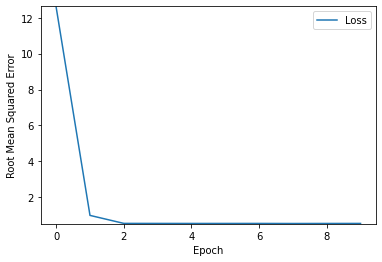

Validation loss: 0.25757136940956116
Validation accuracy: 0.6218487620353699
Validation rmse: 0.5075148940086365


In [407]:
# print and visualize results
print(history.history.keys(), '\n')
print('loss:', history.history['loss'], '\n')
print('accuracy:', history.history['accuracy'], '\n')
# print('True Positive:', history.history['tp'], '\n')
# print('False Positive:', history.history['fp'], '\n')
# print('True Negative:', history.history['tn'], '\n')
# print('False Negative:', history.history['fn'], '\n')
print('Root Mean Squared Error:', history.history['rmse'], '\n')
hist = pd.DataFrame(history.history)
plot_the_loss_curve(history.epoch, hist["rmse"])

# print_performance(history)
score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('Validation rmse:', score[2])

In [405]:
# print(dataset_df['mfcc'][5845:5845 + 10])
# print(dataset_df['label'][5845:5845 + 10])
def predict_gunshot(n, feature, label, model):
  """Predict house values based on a feature."""

  batch = K.cast_to_floatx(dataset_df[feature][5845:5845 + n].tolist())
  predicted_values = model.predict_on_batch(x=batch)
#   print(predicted_values)
#   print(predicted_values[0][0])
#   print(type(predicted_values[0][0]))

  print("feature   label          predicted")
  print("  value   value          value")
  print("                                  ")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0s %6.0f %15.0f" % ('feature',
                                   dataset_df[label][5845 + i],
                                   predicted_values[i][0]))
predict_gunshot(10, 'mfcc', 'label', model)

feature   label          predicted
  value   value          value
                                  
--------------------------------------
           1               0
           0               1
           1               0
           1               0
           1               0
           1               1
           0               1
           0              -0
           0               0
           0               0
